## Extraindo uma playlist de um usuário

Importando as (muitas) bibliotecas necessárias

In [1]:
%matplotlib notebook
#%matplotlib inline

import os
import json
import pandas as pd
import numpy as np
import io
import requests
import subprocess 
from numpy import array
import matplotlib.pyplot as plt
from IPython.display import clear_output



from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors


from random import shuffle
from matplotlib import style
style.use("ggplot")
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from pylab import *



Utilizamos uma API do Spotify que retorna diversas features de uma determinada música. Para isso, precisaremos de um auth token.

Essas são as funções necessárias para acessar cada música

In [2]:
# generate authorization token
def generate_token():
    with open('auth.json') as json_file:  
            data = json.load(json_file)

    auth_64 = data["auth_id"]
    
    
    cmd = ('curl -X "POST" -H "Authorization: Basic {0}" -d grant_type=client_credentials https://accounts.spotify.com/api/token').format(auth_64)

    output = subprocess.check_output(cmd,shell=True)
    tmp = json.loads(output)
    
    return(tmp["access_token"])

# get the playlist id from playlist link
def playlist_extrator(link):
    link = str(link)
    link = link.split('/')
    username = ''
    playlist_id = ''
    for i in range(0,len(link)):
        if link[i] == 'user':
            username = link[i+1]
        elif link[i] == 'playlist':
            playlist_id = link[i+1]
        
    return (username,playlist_id)
# request the playlist info
def generate_request(auth,playlist_link):
    username,playlist_id = playlist_extrator(playlist_link)
    link = ('curl -X GET "https://api.spotify.com/v1/users/{0}/playlists/{1}/tracks?market=BR" -H "Accept: application/json" -H "Authorization: Bearer {2}"'.format(username,playlist_id,auth))
    return link




In [3]:
# lists the musics from a playlist
def list_music(auth,playlist_link):
    
    link  = generate_request(auth,playlist_link)
    output = subprocess.check_output(link,shell=True)
    obj = json.loads(output)
    music = ''
    try:
        for values in obj['tracks']['items']:
            if values['track']['id'] != None:
                music += values['track']['id'] +','
    except:

        for items in obj['items']:
            if items['track']['id'] != None:
                music += items['track']['id'] +','
                
    return music

# get dictionary of music from list of ids

def get_music_from_id(auth,music_list): 
    all_music_id = ('curl -X GET "https://api.spotify.com/v1/audio-features/?ids={0}" -H "Authorization: Bearer {1}"'.format(music,auth))   
    output = subprocess.check_output(all_music_id,shell=True)
    music_feat = json.loads(output)
    return music_feat

Agora, com todas as features em cache, calcular a média e chegar no resultado para toda a playlist 

In [4]:
# get means from music from playlist 
def music_feat_fit(length,music_feat):

    feat = music_feat["audio_features"]
    feat_mean = dict()
    
    danceability = []
    energy = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    valence = []
    loudness = []
    tempo = []
    liveness = []
    
    if music_feat == False:
        
        feat_mean['danceability']       = "None"
        feat_mean['energy']             = "None"
        feat_mean['speechiness']        = "None"
        feat_mean['acousticness']       = "None"
        feat_mean['instrumentalness']   = "None"
        feat_mean['valence']            = "None"
        feat_mean['loudness']           = "None"
        feat_mean['tempo']              = "None"
        feat_mean['liveness']           = "None"

        return feat_mean 
    
    for music in feat:
        try:
            danceability.append(music['danceability'])
            energy.append(music['energy'])
            speechiness.append(music['speechiness'])
            acousticness.append(music['acousticness'])
            instrumentalness.append(music['instrumentalness'])
            valence.append(music['valence'])
            loudness.append(music['loudness'])
            tempo.append(music['tempo'])
            liveness.append(music['liveness'])
        except:
            pass
        
    danceability = pd.Series(danceability)
    energy = pd.Series(energy)
    speechiness = pd.Series(speechiness)
    acousticness = pd.Series(acousticness)
    instrumentalness = pd.Series(instrumentalness)
    valence = pd.Series(valence)
    loudness = pd.Series(loudness)
    tempo = pd.Series(tempo)
    liveness = pd.Series(liveness)
       
    feat_mean['danceability']       = np.mean(danceability)
    feat_mean['energy']             = np.mean(energy)
    feat_mean['speechiness']        = np.mean(speechiness) 
    feat_mean['acousticness']       = np.mean(acousticness)
    feat_mean['instrumentalness']   = np.mean(instrumentalness)
    feat_mean['valence']            = np.mean(valence)
    feat_mean['loudness']           = np.mean(loudness)
    feat_mean['tempo']              = np.mean(tempo)
    feat_mean['liveness']           = np.mean(liveness)
    
    return feat_mean 

In [5]:
# Link da tabela das resposta do form
with open('auth.json') as json_file:  
            data = json.load(json_file)

# Criar um dataframe pelo CSV da tabela      
url = data['url']
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))


## Analisando os atributos de cada playlist

In [6]:
auth = generate_token()

for i, trial in df.iterrows():
#     print(len(trial))
    
#     print(trial[5])
    if len(trial)<=4 or str(trial[5])=="nan": 
        playlist_link = (trial[3])
        music = list_music(auth,playlist_link)
        music_feat = get_music_from_id(auth, music)
        ind_mean = music_feat_fit(len(music_feat["audio_features"]),music_feat) 

        df.loc[i, "danceability"]      = str(ind_mean["danceability"])         
        df.loc[i, "energy"]            = str(ind_mean["energy"])   
        df.loc[i, "speechiness"]       = str(ind_mean["speechiness"])        
        df.loc[i, "acousticness"]      = str(ind_mean["acousticness"])         
        df.loc[i, "instrumentalness"]  = str(ind_mean["instrumentalness"])             
        df.loc[i, "valence"]           = str(ind_mean["valence"])
        df.loc[i, "loudness"]          = str(ind_mean["loudness"])
        df.loc[i, "tempo"]             = str(ind_mean["tempo"])
        df.loc[i, "liveness"]          = str(ind_mean["liveness"])
    
    print(((i+1)/len(df)*100),"%")
        
clear_output()

## Futuramente, faremos uma implementação contínua que, para cada nova resposta do formulário, calculará as novas features e retornará o e-mail automaticamente

In [8]:
#https://www.youtube.com/watch?v=vISRn5qFrkM (tutorial)
import gspread
from oauth2client.service_account import ServiceAccountCredentials

teste = json.loads(df.to_json())

values = []

for coluna in teste.keys():
    buffer = []
    buffer.append(coluna)
    for valor in teste[coluna].keys():
        buffer.append(teste[coluna][valor])
    values.append(buffer)
    
scope = ['https://spreadsheets.google.com/feeds']
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json',scope)
client = gspread.authorize(creds)

# sheet = client.open('Spotifinder (Responses)').sheet1

#cell_list = sheet.range("A1:C7")
#g = sheet.cell(row, col)
#g = sheet.row_values(linha)
#g[2]

# titulos = df.keys()
# coluna = 1
# for i in titulos:
#     sheet.update_cell(1,coluna,i)
#     coluna += 1

Limpando as informações sensíveis das respostas

In [9]:
# Deletando informações pessoais (e-mail e link da playlist do spotify)
try:
    df_names = df['Nome Completo']
    df_email = df['Email Address']
    del df['Nome Completo']
    del df['Timestamp']
    del df['Email Address']
    del df['Link da sua playlist favorita do Spotify']
    del df['group']
    
except:
    pass

# print(df.keys())

In [10]:

# Salvando base de dados para o excel
writer = pd.ExcelWriter('Respostas.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

# Colocar os indices entre 1 e 0
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler((-1,1))
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

df.columns=['danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'valence', 'loudness', 'tempo', 'liveness']

##### Feature extraction|Test cluestering(teste/treinamento)

0    David Fogelman
Name: Nome Completo, dtype: object


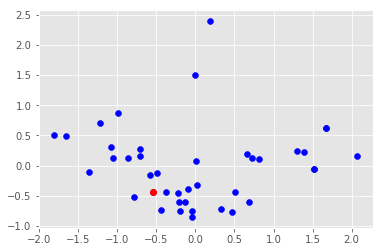

In [12]:
%matplotlib inline
#Aplicação do PCA para redução de 9 para 2 dimensões
X = np.array(df)
pca = PCA(n_components=2)
pca.fit(X)

num_pessoa = 0
num_pessoa_1 = num_pessoa+1
if num_pessoa >= len(df_names):
    num_pessoa_1 = num_pessoa
print(df_names[num_pessoa:num_pessoa_1])

reduct = pca.transform(X)
plt.scatter(reduct[:,0],reduct[:,1],c = 'b')

plt.plot(reduct[num_pessoa,0],reduct[num_pessoa,1],'ro')
plt.show()

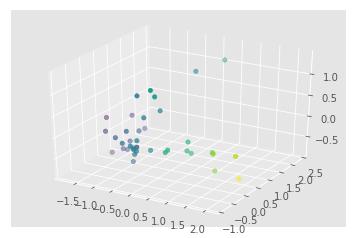

In [14]:
# %matplotlib notebook

#Aplicação do PCA para redução de 9 para 3 dimensões

A = np.array(df)
pca = PCA(n_components=3)
pca.fit(A)

# print(pca.get_precision(A))

Areduct = pca.transform(A)

x = Areduct[:,0] 
y = Areduct[:,1]
z = Areduct[:,2]
# c = Areduct[:,3]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=x)
plt.show()

Cluster 0 contains 11 samples
Cluster 1 contains 5 samples
Cluster 2 contains 7 samples
Cluster 3 contains 2 samples
Cluster 4 contains 5 samples
Cluster 5 contains 11 samples


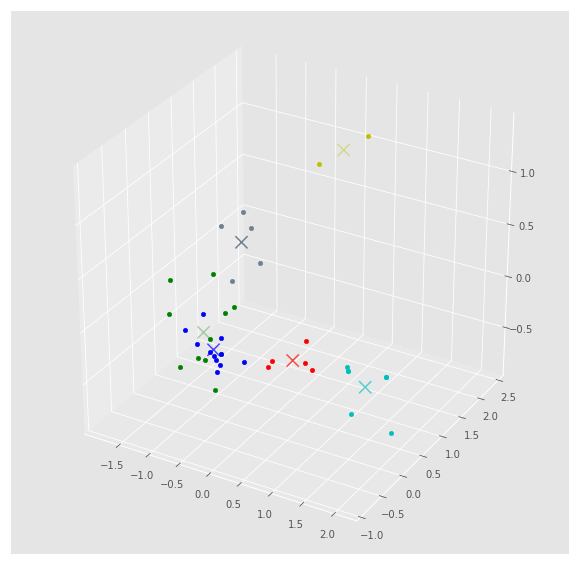

In [16]:
#Cluster tridimensional

X = Areduct
cluster_num = int((len(Areduct))**(1/2))

kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(Areduct)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

colors = ['g','r','c','y','slategray', 'b', 'm']
# shuffle(colors)
colors = colors[:cluster_num]

c = Counter(labels)
# print(c)

fig = figure(figsize=(10,10))
# fig = figure()
ax = fig.gca(projection='3d')


for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[labels[i]]) #color[labels[i]]
    pass
for cluster_number in range(cluster_num):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

ax.scatter(centroids[:, 0],centroids[:, 1], centroids[:, 2], marker = "x", s=150, linewidths = 5, zorder = 100, c=colors)
plt.show()

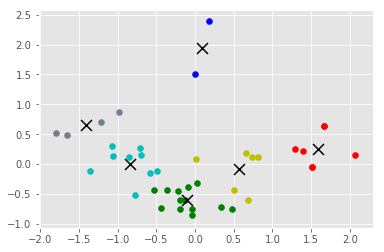

In [17]:
#Clusterização com as 2 dimensões
X = reduct
cluster_num = int((len(reduct))**(1/2))

kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(reduct)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

colors = ['g','r','c','y','slategray', 'b', 'm']
# shuffle(colors)
colors = colors[:cluster_num]

c = Counter(labels)


fig = figure()
ax = fig.gca()


for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1], c=colors[labels[i]]) #color[labels[i]]
    pass

ax.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=120, linewidths = 20, zorder = 10,c="k" )#c=colors


In [18]:
#Adição dos clusters no dataframe
df['labels']  = labels
Xx = []
Xy = []
for i in X:
    Xx.append(i[0])
    Xy.append(i[1])
Xx = np.array(Xx)
Xy = np.array(Xy)
df["PCAx"] = Xx
df["PCAy"] = Xy

#df = df.sort_values(by=['labels'])
def calc_dist(A,B):
    dist = math.sqrt((A[1]-B[1])**2+(A[0]-B[0])**2)
    return dist
 
df = df.sort_index()


In [19]:
#Implementação da função NearestNeighbors para encontrar os *nearestNeighbors ;)
for i in list(c.keys()):
    DFgrupo = df.loc[df["labels"] == i]
    X = DFgrupo.as_matrix(["PCAx","PCAy"])
    index = list(df[df["labels"] == i].index)
    if(len(X) >= 3):
        nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(X)
        distances, indices = nbrs.kneighbors(X)
        viz1 = []
        viz2 = []
        for k in indices:
            viz1.append(DFgrupo.index[k[1]])
            viz2.append(DFgrupo.index[k[2]])

        df.loc[df["labels"] == i,'vizinho1'] = viz1
        df.loc[df["labels"] == i,'vizinho2'] = viz2
    else:
        df.loc[df["labels"] == i,'vizinho1'] = index[0]
        df.loc[df["labels"] == i,'vizinho2'] = index[1]
#df

In [21]:
#Trocar os índices por nomes
df['nomes'] = df_names
respostas = pd.DataFrame()
respostas["nome"] = df["nomes"]
viz1 = []
viz2 = []
for i in range(len(df)):
    if df.loc[i,'vizinho1'] != -1:    
        viz1.append(df.loc[df.loc[i,'vizinho1'],'nomes'])
        viz2.append(df.loc[df.loc[i,'vizinho2'],'nomes'])
    else:
        viz1.append(-1)
        viz2.append(-1)


respostas['vizinho1'] = viz1
respostas['vizinho2'] = viz2
respostas['email'] = df_email

In [22]:
respostas

,nome,vizinho1,vizinho2,email
0,David Fogelman,Rodrigo Coutinho,Ana Capriles,david@anf.com.br
1,Wesley Gabriel Albano Da Silva,Barbara Freire,Pedro Silva,wesleygl16@gmail.com
2,André Neustein,Giovana Lemes,Luigi Crespi Corradi,andreneustein@gmail.com
3,Luca Salimon Nascimento,Luca Salimon Nascimento,Luca Ribeiro Noto,lucasalnasci@gmail.com
4,Manoela Cirne Lima De Campos,Gabriella Nazario,Guilherme Benavente Chicarelle,manucirne@gmail.com
5,Pedro Villas Boas Dias,Juliana Costa Pessoa,Barbara Freire,pedrovillas@hotmail.com.br
6,Rodrigo Coutinho,João Gabriel Rodrigues Edivirges,David Fogelman,rodrigogacoutinho@gmail.com
7,Emanuelle Moço,Eli jose abi ghosn,João Gabriel Rodrigues Edivirges,emanuellesmoco@gmail.com
8,Giovana Lemes,André Neustein,Luigi Crespi Corradi,giiiolemes@gmail.com
9,Gabriel Pizzighini Salvador,Pedro Oliveira de Azambuja,João Gabriel Rodrigues Edivirges,gpizzigh@hotmail.com
